In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#comienzo de metrics.py
#solo necesito poder evaluar con las metricas
#las hago como funciones

#ambas reciben los scores de la prediccion (scores) y los scores verdaderos (y)
#retorna la metrica correspondiente
#chequeado ok ej 8

def accuracy(scores,y):
    acc = np.mean(scores == y) #calculo accuracy
    return acc

def MSE(scores,y):
    mse = np.mean(np.sum((scores-y)**2,axis=1))
    return mse

#esta es especifica para el problema del XOR
def accuracy_xor(scores,y):
    scores[scores>0.9] = 1 #umbral que aconsejaron en clase
    scores[scores<-0.9] = -1 #idem 
    acc = np.mean(scores==y)
    return acc

In [3]:
#comienzo de loss.py
#lo codeo aca y despues lo paso a otro archivo
#chequeado ok ej8

class Loss:
    def __init__(self):
        pass
    def __call__(self,scores,y):
        pass
    def gradient(self,scores,y):
        pass
    
class MSE(Loss):
    def __init__(self):
        super().__init__()
    def __call__(self,scores,y):
        mse = np.mean(np.sum((scores-y)**2,axis=1))
        return mse
    def gradient(self,scores,y):
        gradmse = (scores-y)*2
        return gradmse
    
class CCE(Loss):
    def __init__(self):
        super().__init__()
    def __call__(self,scores,y):
        scoresmax = scores.max(axis=1) #maximo de cada fila
        scores = scores - scoresmax[:,np.newaxis] #le resto a cada fila el maximo correspondiente
        y = np.argmax(y,axis=1)
        scores_yi = scores[np.arange(scores.shape[0]),y] #estos son los f_yi
        expscores = np.exp(scores) #hace exp(scores)
        sum_expscores = expscores.sum(axis=1) #suma de los exp(scores) por fila 
        loss = np.log(sum_expscores) - scores_yi #aca estan las loss_i en vector fila
        loss = loss.mean() #vector fila, solo hago el mean, no sobre algun axis particular
        return loss
    def gradient(self,scores,y):
        y = np.argmax(y,axis=1)
        y = y.flatten()
        scoresmax = scores.max(axis=1) #maximo de cada fila
        scores = scores - scoresmax[:,np.newaxis] #le resto a cada fila el maximo correspondiente
        scores_yi = scores[np.arange(scores.shape[0]),y] #estos son los f_yi
        expscores = np.exp(scores) #hace exp(scores)
        sum_expscores = expscores.sum(axis=1) #suma de los exp(scores) por fila 
        grad = (1/sum_expscores)[:,np.newaxis]*expscores
        grad[np.arange(y.shape[0]),y] = grad[np.arange(y.shape[0]),y] - 1
        return grad
    

In [4]:
#comienzo de activation.py
#lo codeo aca y despues lo paso a otro archivo
#ok, modificado y corregido ej 8

#una estructura similar a la de Loss
class Activation:
    def __init__(self):
        pass
    def __call__(self,x):
        pass
    def gradient(self,x):
        pass

class ReLu(Activation):
    def __init__(self):
        super().__init__()
    def __call__(self,x):
        return np.maximum(0,x)
    def gradient(self,x):
        res = np.where(x>=0,1,0)
        return res

class Tanh(Activation):
    def __init__(self):
        super().__init__()
    def __call__(self,x):
        return np.tanh(x)
    def gradient(self,x):
        y = (np.cosh(x))**(-2)
        return y

class Sigmoid(Activation):
    def __init__(self):
        super().__init__()
    def __call__(self,x):
        sig = (1+np.exp(-x))**(-1)
        return sig
    def gradient(self,x):
        gsig = (np.exp(-x))/((1+np.exp(-x))**2)
        return gsig


In [5]:
#comienzo de optimizers.py
#lo codeo aca y despues lo paso a otro archivo
#chequeado ej 8 hasta aca

class Optimizer():
    def __init__(self,lr):
        self.lr = lr #el learning rate
        #podria eventualmente haber mas cosas aca
    def __call__(self, X, Y, model):
        pass
    def update_weights(self, W, gradW):
        pass

class SGD(Optimizer):
    def __init__(self, lr, bs):
        super().__init__(lr)
        self.bs = bs
    def randomizeMatrixRows(self,x,y):
        #x matriz de imagenes (imagenes x dimension)
        #y matriz de scores verdaderos (imagenes x categorias)
        indices = np.random.choice(x.shape[0], x.shape[0], replace=False)
        x1 = x[indices]
        y1 = y[indices]
        return x1,y1
    def __call__(self, X, Y, model,loss):
        nit = int(X.shape[0]/self.bs) #numero de iteraciones
        X1,Y1 = self.randomizeMatrixRows(X,Y) #shuffle de las imagenes
        for j in range(nit):
            X_batch = X1[j*self.bs:(j+1)*self.bs,:] #seleccion de batch
            Y_batch = Y1[j*self.bs:(j+1)*self.bs]
            scores = model.return_scores(X_batch) #variable auxiliar para el calculo de despues 
            model.grad = loss.gradient(scores,Y_batch) #esto es para el backwards despues, gradiente del ultimo paso del loss
            model.backward(X_batch, Y_batch,self.lr) #backwards de model
    def update_weights(self, W, gradW):
        W -= self.lr * gradW # SGD, paso de optimizacion despues de calcular gradW
        return W

In [6]:
#comienzo de layers.py
#lo codeo aca y despues lo paso a otro archivo

#chequeado todo aca tambien

#base para cualquier tipo de layer/capa
class BaseLayer():
    def __init__(self):
        pass
    def set_output_shape(self):
        pass
    def get_output_shape(self):
        pass
    
#clases para capas especiales sin pesos

#clase especial de Layer que es la de Input o entrada
class Input(BaseLayer):
    def __init__(self,dim_input): #donde dim_xi va a ser la dimension del input de toda la red
        super().__init__()
        self.dim_input = dim_input
    def set_output_shape(self,dim):
        self.dim_input = dim
    def get_output_shape(self):
        return self.dim_input
    
#capa de concatenacion que me va a servir para realimentacion
class Concat(BaseLayer):
    def __init__(self,input_layer):
        super().__init__()
        self.dim_1 = input_layer.get_output_shape()
        self.dim_2 = None
        self.dim_output = None
        #la creo como clase vacia en principio
    #concatena los input que le de al llamar al objeto como funcion 
    def __call__(self,x,y):
        #concateno los inputs con los que llamo a la capa de concatenacion
        xy_concat = np.hstack((x,y))
        return xy_concat
    def set_input_shape(self,dim2): #seteo el input shape que va a venir de la neurona anterior
        self.dim_2 = dim2
    def get_input1_shape(self):
        return self.dim_1
    def get_input2_shape(self):
        return self.dim_2
    def get_output_shape(self):
        return self.dim_1 + self.dim_2
    def set_output_shape(self,dim):
        self.dim_output = dim #no entiendo muy bien para que es esto, despues lo veremos
    def grad_concat(self,scores):
        scores = scores[:,self.get_input1_shape():] #creo que asi esta bien, el bias no se lo pongo
        return scores
        
#clases para capas densas con pesos 

#clase padre para capas con pesos WLayer
class WLayer(BaseLayer):
    def __init__(self,n_neuronas,activacion,mg=1,input_dim=0): 
        #input_dim es opcional, sino lo saco de otra capa
        #el resto si lo necesito y es propio de cada capa
        super().__init__()
        self.output_dim = n_neuronas #numero de neuronas, esto es output_dim
        self.activacion = activacion #funcion de activacion de la capa
        self.input_dim = input_dim #dimension del problema, no de los ejemplos
        self.W = None #estos son los pesos de la capa en cuestion
        self.mg = mg
    def get_input_shape(self):
        return self.input_dim
    def set_input_shape(self,input_dim):
        self.input_dim = input_dim
    def get_output_shape(self):
        return self.output_dim
    def set_output_shape(self,output_dim):
        self.output_dim = output_dim
    def init_weights(self): #funcion que inicializa los pesos, idem para todo tipo de cada que podria tener 
        #self.W = np.zeros(input_dim+1,output_dim) el +1 es por bias, recordatorio de las dimensiones
        self.W = np.random.rand(self.input_dim + 1,self.output_dim) * self.mg
    def get_weights(self): #devuelve la matriz de pesos
        return self.W
    def update_weights(self,W_new):
        #susceptible a modificaciones
        #actualiza los pesos, creo que asi esta ok
        self.W = W_new
    def addBias(self,x):
        aux = np.ones((x.shape[0],1))
        x_bias = np.hstack((aux,x))
        return x_bias
        
#clase heredada de WLayer, capa de neuronas densa
class Dense(WLayer):
    def __init__(self,n_neuronas,activacion,mg=1,input_dim=0): 
        #herencia de la clase WLayer, es el mismo constructor
        super().__init__(n_neuronas,activacion,mg,input_dim)
        self.y_i = None
    def dot(self,x): #esto devuelve s_i 
        x_prime = self.addBias(x) #es el x' con el bias aniadido
        y = x_prime.dot(self.W) #multiplicacion
        self.y_i = np.copy(y)
        y = self.activacion(y) #aplica la activacion
        return y
    def __call__(self,x):
        return self.dot(x)

In [7]:
#comienzo de models.py
#lo codeo aca y despues lo paso a otro archivo

class Network():
    def __init__(self):
        self.list_neuronas = [] #lista de neuronas
        self.grad = None #variable auxiliar, despues del fit calculo el gradiente con la loss y despues lo termino en backward
        self.optm = None #para poder usarlo en backwards para actualizar los pesos
    def add(self,capa_neuronas):
        #chequeo si es la primera capa
        if (len(self.list_neuronas) != 0):
            output_old_neurona = (self.list_neuronas[len(self.list_neuronas)-1]).get_output_shape()
            capa_neuronas.set_input_shape(output_old_neurona) #seteo el input de la nueva neurona
        if(isinstance(capa_neuronas,Concat)):
            pass
        else:
            capa_neuronas.init_weights() #inicializo
        self.list_neuronas.append(capa_neuronas) #aniado neurona a la lista
    def get_layer(self,numero_layer): #devuelve la layer dado el numero de la layer que quiero
        return self.list_neuronas[numero_layer] #empieza desde la capa 0
    def fit (self,x,y,x_test=None,y_test=None,lr = 1e-3,epochs = 100,bs = 100,acc = accuracy_xor, loss_class = MSE,opt_class = SGD):
        optm = opt_class(lr,bs) #creo objeto de optimizador, hace loop de batchs
        self.optm = optm
        x_test = np.array(x_test)
        loss = loss_class() #creo objeto loss  
        loss_tr = [] #vector de loss de datos de training
        loss_ts = [] #vector de loss de datos de testing
        acc_tr = [] #vector de accuracy de datos de training
        acc_ts = [] #vector de accuracy de datos de testing
        for ie in range(epochs):
            #forward la primera vez, devuelvo el gradiente de la loss escencialmente
            #backward path
            optm(x,y,self,loss) #hago call del optimizador, que hace backwards una vez y update de los pesos
            #calculo loss y accuracy para los datos de training
            scores = self.return_scores(x) #aniado esta funcion que me devuelve los scores solamente despues de actualizar
            loss_aux = loss(scores,y) #calculo loss de los datos de training
            acc_aux = acc(scores,y) #calculo accuracy de los datos de training
            loss_tr.append(loss_aux) #aniado la loss de los de training 
            acc_tr.append(acc_aux)  #aniado la accuracy de los de training
            print("training data: ",loss_aux,acc_aux) #printeo loss y acc de training data
            #hago lo mismo para los datos de testing basicamente
            if(x_test != None):
                scores = self.scores(x_test)
                loss_aux = loss(scores,y_test)
                acc_aux = acc(scores,y_test)
                loss_ts.append(loss_aux)
                acc_ts.append(acc_aux)
                print("testing data: ",loss_aux,acc_aux) #printeo loss y acc de testing data
        return loss_tr,loss_ts,acc_tr,acc_ts
    def forward_upto(self,x_input,j): 
        #hace forward hasta la capa j-esima 
        s_i = np.copy(x_input)
        for i in range(j+1):
            if(isinstance(self.list_neuronas[i],Concat)):
                s_i = self.list_neuronas[i](x_input,s_i)
            else:
                s_i = self.list_neuronas[i](s_i) #estos son los s_i que salen de cada neurona 
        return s_i #devuelve el resultado de forward up to j-esima capa
    def return_scores(self,x): #retorna los scores
        scores = self.forward_upto(x,len(self.list_neuronas)-1)
        return scores
    def predict(self,x): #calcula los scores con la funcion anterior y devuelve la prediccion
        scores = self.return_scores(x)
        y = np.argmax(scores,axis=1)
        return y
    def backward(self,x,y,lr):
        #le paso self, los datos x,y y lr es el learning rate porque a esta funcion la llama el opt
        #y me parece que es la manera mas facil de actualizar los pesos 
        n_capas = len(self.list_neuronas) #cantidad total de capas totales
        grad = self.grad #idem anterior
        for j in reversed(range(n_capas)): #recorro hasta la capa 0 de input
            capa_actual = self.get_layer(j) #capa actual de trabajo
            capa_anterior = self.get_layer(j-1)
            s_i_ant = self.forward_upto(x,j-1) #s_i de la capa i-1, capa anterior
            if(isinstance(capa_actual,Concat)):
                grad = capa_actual.grad_concat(grad)
            else:
                #sino es una de concatenacion (o sea, es densa basicamente)
                grad = grad * capa_actual.activacion.gradient(capa_actual.y_i)
                s_i_ant = capa_actual.addBias(s_i_ant)
                grad_wi = (s_i_ant.T).dot(grad)
                grad = grad.dot(capa_actual.W.T)
                grad = grad[:,1:]
                capa_actual.W = self.optm.update_weights(capa_actual.W,grad_wi)
        
            

In [8]:
#problema XOR 1

In [21]:
# Dataset
x_train = np.array([[-1,-1],[-1,1],[1,-1],[1,1]])
y_train = np.array([[1],[-1],[-1],[1]])
model = Network() #creo una network
mg=1
layer_1 = Dense(2,Tanh(),mg,x_train.shape[1]) #capa 1
model.add(layer_1) #aniado la primera capa a la red
layer_2 = Dense(1,Tanh(),mg) #creo la capa 2
model.add(layer_2) #aniado la segunda capa a la red
epocas = 300 #cantidad de epocas a realizar
lr = 0.05 #learning rate
bs = x_train.shape[0] #batch size para stochastic gradient descendent
#def fit (self,x,y,x_test=None,y_test=None,lr = 1e-3,epochs = 100,bs = 100,acc = accuracy_xor, loss_class = MSE,opt_class = SGD):
loss_tr,loss_ts,acc_tr,acc_ts = model.fit(x_train,y_train,None,None,lr,epocas,bs,accuracy_xor,MSE,SGD)

training data:  1.5627783055138615 0.0
training data:  1.373588434199891 0.0
training data:  1.2025956631547117 0.0
training data:  1.0793789927122601 0.0
training data:  1.0082074511724377 0.0
training data:  0.9721061709378208 0.0
training data:  0.9514478588021594 0.0
training data:  0.9356450795688406 0.0
training data:  0.9210492176056178 0.0
training data:  0.9067989826479391 0.0
training data:  0.8929062729416251 0.0
training data:  0.8796065171282558 0.0
training data:  0.8671387938170563 0.0
training data:  0.8556664712024704 0.0
training data:  0.845256717726304 0.0
training data:  0.8358910546593512 0.0
training data:  0.8274903786765393 0.0
training data:  0.8199422799343359 0.0
training data:  0.8131233577591197 0.0
training data:  0.8069139176163613 0.0
training data:  0.8012055733371272 0.0
training data:  0.7959036425258195 0.0
training data:  0.7909263505613771 0.0
training data:  0.7862024149106952 0.0
training data:  0.7816680246125043 0.0
training data:  0.777263774

([<matplotlib.axis.YTick at 0x23f62772f88>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

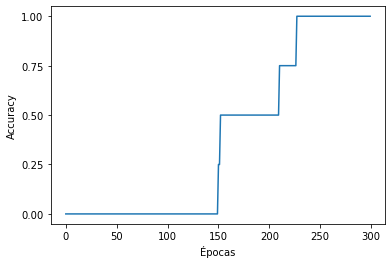

In [22]:
e = range(epocas)
plt.plot(e,acc_tr)
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.25, step=0.25))
#plt.savefig('ej6sit1_accepoch0p5.pdf')

Text(0, 0.5, 'Loss')

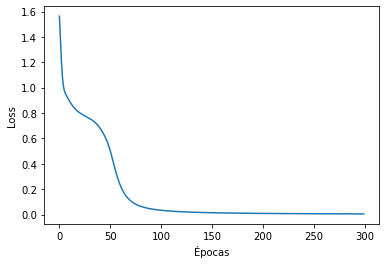

In [23]:
plt.plot(e,loss_tr)
plt.xlabel('Épocas')
plt.ylabel('Loss')
#plt.savefig('ej6sit1_lossepoch0p5.pdf')

In [12]:
#problema 6 XOR 2

In [18]:
#Dataset
x_train = np.array([[-1,-1],[-1,1],[1,-1],[1,1]])
y_train = np.array([[1],[-1],[-1],[1]])

input_layer = Input(x_train.shape[1]) #input layer, la creamos para crear la concat layer despues
layer_1 = Dense(2,Tanh(),mg,x_train.shape[1]) #capa 1
layer_2 = Dense(1,Tanh(),mg) #creo la capa 2

model = Network() #creo objeto tipo network

model.add(layer_1) #aniado la primera capa a la red
model.add(Concat(input_layer))
model.add(layer_2) #aniado la segunda capa a la red

epocas = 300 #cantidad de epocas a realizar
lr = 0.05 #learning rate
bs = x_train.shape[0] #batch size para stochastic gradient descendent


loss_tr,loss_ts,acc_tr,acc_ts = model.fit(x_train,y_train,None,None,lr,epocas,bs,accuracy_xor,MSE,SGD)

training data:  1.7778093273467979 0.25
training data:  1.4819772273318095 0.0
training data:  1.230511124006487 0.0
training data:  1.083144881628177 0.0
training data:  1.0189966520591676 0.0
training data:  0.9824782913490543 0.0
training data:  0.9579579342983093 0.0
training data:  0.9396716745415724 0.0
training data:  0.9215819344352274 0.0
training data:  0.9008910106697741 0.0
training data:  0.8764924353235636 0.0
training data:  0.8477480354958982 0.0
training data:  0.8142649784460101 0.0
training data:  0.7759676050971189 0.0
training data:  0.7332083343749981 0.0
training data:  0.6868137793914859 0.0
training data:  0.6380109964779731 0.0
training data:  0.5882438253263099 0.0
training data:  0.5389495389783601 0.0
training data:  0.49137418849179393 0.0
training data:  0.4464667233287133 0.0
training data:  0.40485020989181236 0.0
training data:  0.3668478242076383 0.0
training data:  0.33253856490345635 0.0
training data:  0.30182265836524724 0.0
training data:  0.2744

([<matplotlib.axis.YTick at 0x23f626a0988>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

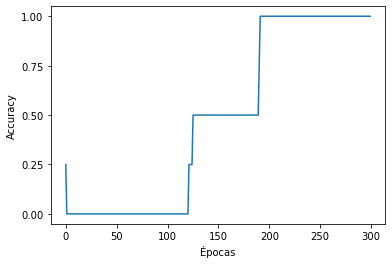

In [19]:
e = range(epocas)
plt.plot(e,acc_tr)
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.25, step=0.25))
#plt.savefig('ej6sit2_accepoch0p5.pdf')

Text(0, 0.5, 'Loss')

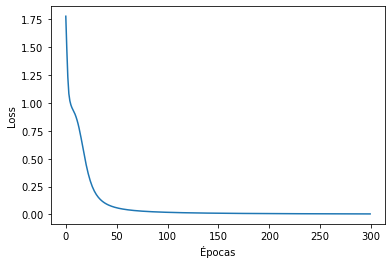

In [20]:
plt.plot(e,loss_tr)
plt.xlabel('Épocas')
plt.ylabel('Loss')
#plt.savefig('ej6sit2_lossepoch0p5.pdf')